<a href="https://colab.research.google.com/github/seanlaughlin/AITradingBot/blob/master/ROIBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install yfinance ta joblib

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=95a68142141ef19fc37487ea28a66e439739bf5d0809c6bd47ded77424f91b65
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [4]:
# import dependencies

import yfinance as yf
import pandas as pd
import numpy as np
import joblib
from ta.trend import MACD
from ta.momentum import roc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import model_from_json

In [5]:
# loss function

def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    large_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, large_error_loss)

In [6]:
# data download and prep

# download candle data
data = yf.download('SPY', start='2024-03-15', end='2024-04-14', interval='15m')

# add features
macd = MACD(data['Close'])
data['MACD'] = macd.macd()
data['MACD_Signal'] = macd.macd_signal()
data['Momentum'] = roc(data['Close'])

# create features
data['MACD_Cross'] = np.where((data['MACD'] > data['MACD_Signal']) & (
                data['MACD'].shift(1) <= data['MACD_Signal'].shift(1)), 1, 0) # binary feature, indicating whether MACD has crossed signal line since last candle
data['Momentum_Change'] = data['Momentum'].diff()

# add target variable
data['ROI'] = data['Close'].shift(-1) - data['Close']

[*********************100%%**********************]  1 of 1 completed


In [7]:
# data cleaning, output/input split, scaling, train/test split

features = ['Close', 'Volume', 'Momentum', 'MACD_Cross', 'Momentum_Change']
data = data.dropna()
X = data[features].values
y = data['ROI'].values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

joblib.dump(scaler_X, 'scaler_X.pkl') # creates output file for x scaler

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

joblib.dump(scaler_y, 'scaler_y.pkl') # creates output file for y scaler

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [8]:
# building model and train

model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=32))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss=huber_loss)

history = model.fit(X_train, y_train, epochs=150, batch_size=16, validation_split=0.1) # epochs chosen to minimise val loss - more results in more overfitting

Epoch 1/150
22/22 [==============================] - 15s 202ms/step - loss: 0.1669 - val_loss: 0.3119
Epoch 2/150
22/22 [==============================] - 0s 19ms/step - loss: 0.1666 - val_loss: 0.3115
Epoch 3/150
22/22 [==============================] - 0s 18ms/step - loss: 0.1665 - val_loss: 0.3099
Epoch 4/150
22/22 [==============================] - 0s 18ms/step - loss: 0.1667 - val_loss: 0.3113
Epoch 5/150
22/22 [==============================] - 0s 21ms/step - loss: 0.1666 - val_loss: 0.3095
Epoch 6/150
22/22 [==============================] - 1s 26ms/step - loss: 0.1663 - val_loss: 0.3096
Epoch 7/150
22/22 [==============================] - 0s 17ms/step - loss: 0.1663 - val_loss: 0.3100
Epoch 8/150
22/22 [==============================] - 0s 19ms/step - loss: 0.1666 - val_loss: 0.3111
Epoch 9/150
22/22 [==============================] - 0s 20ms/step - loss: 0.1664 - val_loss: 0.3102
Epoch 10/150
22/22 [==============================] - 1s 23ms/step - loss: 0.1665 - val_loss: 0.31

In [9]:
# evaluation and predictions

train_score = model.evaluate(X_train, y_train)
test_score = model.evaluate(X_test, y_test)
print(f'Train MSE: {train_score}')
print(f'Test MSE: {test_score}')

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

4/4 [==============================] - 0s 5ms/step - loss: 0.2392
Train MSE: 0.1407250314950943
Test MSE: 0.23922057449817657
4/4 [==============================] - 0s 5ms/step


In [10]:
# inverse scaling for actual values to be used in charts
train_predict_actual = scaler_y.inverse_transform(train_predict)
test_predict_actual = scaler_y.inverse_transform(test_predict)

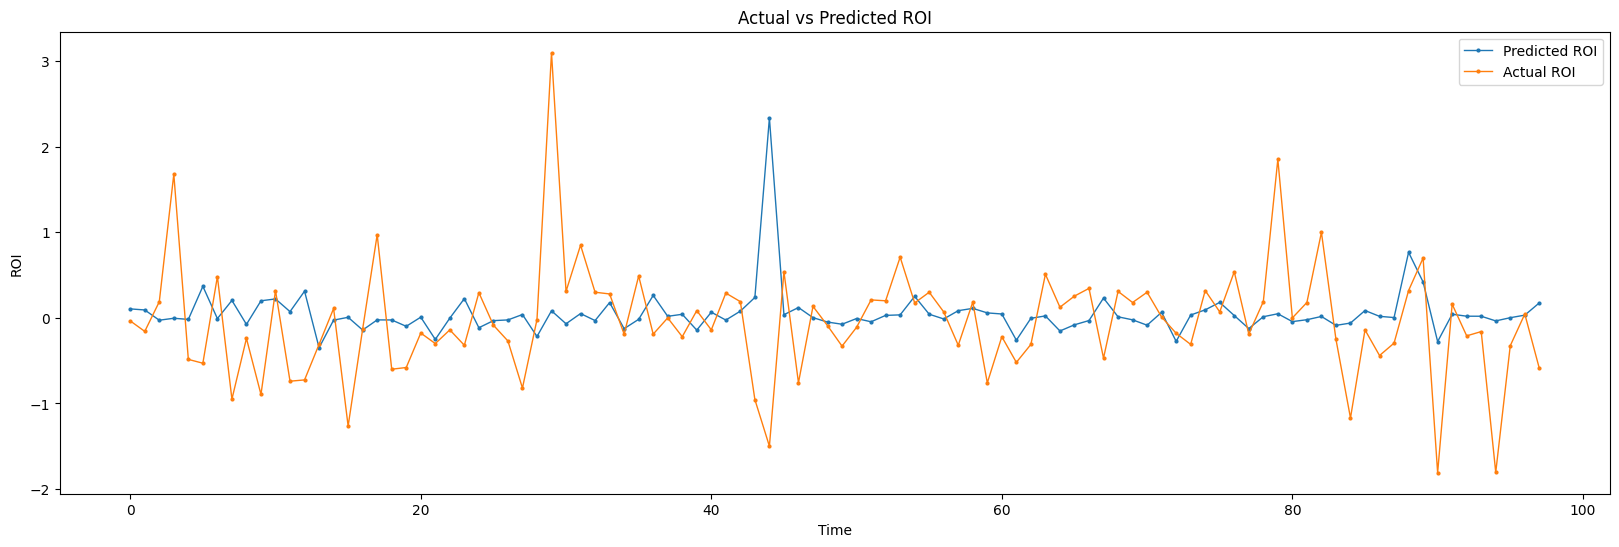

In [11]:
# chart for actual vs predicted ROI

plt.figure(figsize=(20, 6))
plt.plot(test_predict_actual, label='Predicted ROI', marker='o', markersize=2, linewidth=1)
plt.plot(y_test, label='Actual ROI', marker='o', markersize=2, linewidth=1)
plt.xlabel('Time (15 min intervals)')
plt.ylabel('ROI')
plt.title('Actual vs Predicted ROI')
plt.legend()
plt.show()

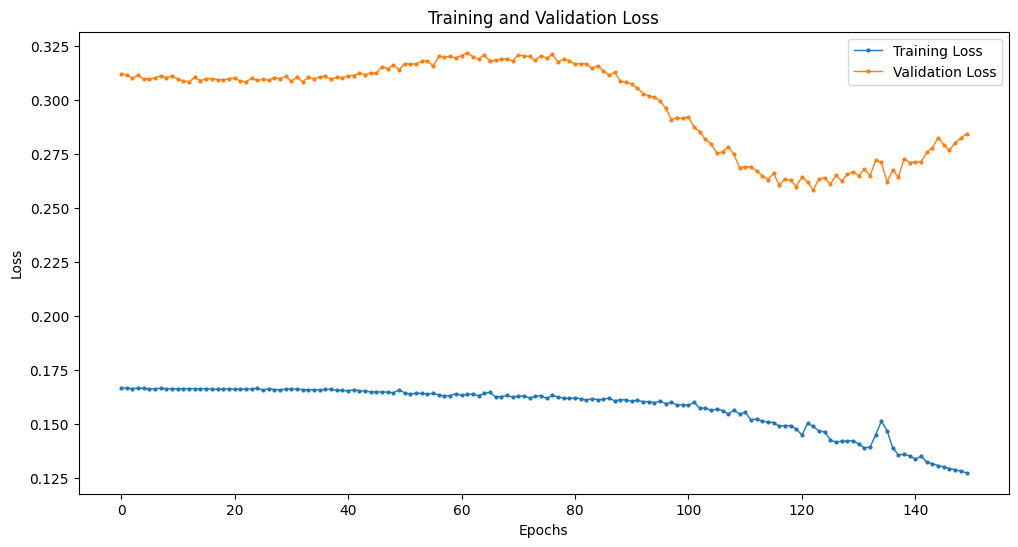

In [12]:
# training and validation loss chart

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], marker='o', markersize=2, linewidth=1, label='Training Loss')
plt.plot(history.history['val_loss'], marker='o', markersize=2, linewidth=1, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [13]:
# simulated trading based off roi predictions, comparison with actual profit ('close' price of next candle minus close price of previous = actual roi)
# NOTE: these figures will not be entirely accurate as prices are based off 'mid price' received from yfinance (middle of bid and ask prices)

data['Predicted_ROI'] = np.concatenate([train_predict_actual, test_predict_actual])
data['Buy_Signal'] = np.where(data['Predicted_ROI'] > 0, 1, 0)
data['Sell_Signal'] = np.where(data['Predicted_ROI'] < 0, 1, 0)

position = 0
previous_price = None
profit_loss_list = []

for index, row in data.iterrows():
    if row['Buy_Signal'] == 1 and position == 0:
        position = 1
        previous_price = row['Close']
    elif row['Sell_Signal'] == 1 and position == 1:
        profit_loss = row['Close'] - previous_price
        profit_loss_list.append(profit_loss)
        position = 0

profit_loss_series = pd.Series(profit_loss_list)

cumulative_profit_loss = profit_loss_series.cumsum()

<ipython-input-13-8457a9799cd8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Predicted_ROI'] = np.concatenate([train_predict_actual, test_predict_actual])
<ipython-input-13-8457a9799cd8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Buy_Signal'] = np.where(data['Predicted_ROI'] > 0, 1, 0)
<ipython-input-13-8457a9799cd8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

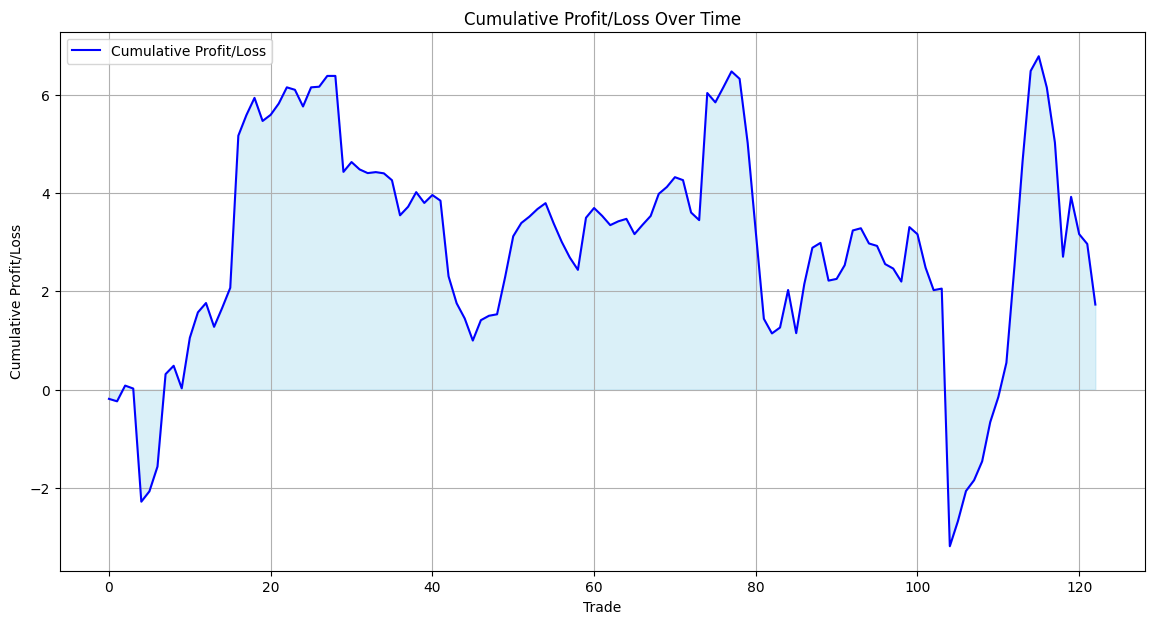

In [14]:
# plot simulated profit results

plt.figure(figsize=(14, 7))
plt.plot(cumulative_profit_loss, label='Cumulative Profit/Loss', color='blue')
plt.fill_between(cumulative_profit_loss.index, cumulative_profit_loss, color='skyblue', alpha=0.3)
plt.title('Cumulative Profit/Loss Over Time')
plt.xlabel('Number of Trades')
plt.ylabel('Cumulative Profit/Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# print model architecture json for export (c&p) and export model weights to file

model_architecture = model.to_json()
print(model_architecture)
model.save("data/lstm_model.h5")

{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 5, 1], "dtype": "float32", "sparse": false, "ragged": false, "name": "lstm_input"}, "registered_name": null}, {"module": "keras.layers", "class_name": "LSTM", "config": {"name": "lstm", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 5, 1], "return_sequences": true, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "time_major": false, "units": 32, "activation": "tanh", "recurrent_activation": "sigmoid", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "recurrent_initializer": {"module": "keras.initializers", "class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
